In [1]:
#%%configure
#{"vCores": 2 }

# Install Package

In [2]:
!pip install     -q deltalake       --upgrade
!pip install     -q pandas          --upgrade
!pip install     -q duckdb          --pre --upgrade
!pip install     -q polars          --pre --upgrade
!pip install     -q daft            --upgrade
!pip install     -q pysail          --upgrade
!pip install     -q pyspark-client  --upgrade
notebookutils.session.restartPython()

sys.exit called with value 0. The interpreter will be restarted.


***Import***

In [3]:
import time
import os
import pandas    as pd
from   datetime  import datetime
from   psutil    import *
from   deltalake import write_deltalake , DeltaTable

In [4]:
core = cpu_count()
vCPU = str(core) + " vCPU"
mem=int(virtual_memory().total/(1024 * 1024 * 1024))
print(vCPU +' Memory:'+ str(mem))

2 vCPU Memory:15


In [5]:
ws                 = 'largedata'
lh                 = 'temp'
result_path        = f'abfss://{ws}@onelake.dfs.fabric.microsoft.com/{lh}.Lakehouse/Tables/dbo/results'
Table_Path_abfss   = f'abfss://{ws}@onelake.dfs.fabric.microsoft.com/{lh}.Lakehouse/Tables'

# Generate Data

In [6]:
%%time
tpch_tables = ['nation','region','customer','supplier','lineitem','orders','partsupp','part']
Table_Path = '/lakehouse/default/Tables'
def define_schema(SF):
    return "CH" + f"{SF:g}".replace('.', '_').zfill(5)
def generate_date(SF):
    import pathlib
    schema = define_schema(SF)
    BASE_OUTPUT_DIR   = f"{Table_Path}/{schema}"
    if not pathlib.Path(f'{Table_Path}/{schema}').exists():
        !pip install -q tpchgen-cli
        !pip install -q deltalake
        from   deltalake  import convert_to_deltalake
        print('generate new data')
        !tpchgen-cli -s {SF} --output-dir {BASE_OUTPUT_DIR} --parts {max(1, int(200 * (SF / 1000)))} --format parquet --parquet-row-group-bytes=268435456
        for tbl in tpch_tables:
          convert_to_deltalake(f'{BASE_OUTPUT_DIR}/{tbl}',storage_options={"allow_unsafe_rename":"true"})
    return "done"

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


# SQL Query

In [7]:
def sql_query(SF):
   return f'''
        SELECT
            --Query01
            l_returnflag,
            l_linestatus,
            SUM(l_quantity) AS sum_qty,
            SUM(l_extendedprice) AS sum_base_price,
            SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
            SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
            AVG(l_quantity) AS avg_qty,
            AVG(l_extendedprice) AS avg_price,
            AVG(l_discount) AS avg_disc,
            COUNT(*) AS count_order
        FROM
            lineitem
        WHERE
            l_shipdate <= CAST('1998-09-02' AS date)
        GROUP BY
            l_returnflag,
            l_linestatus
        ORDER BY
            l_returnflag,
            l_linestatus;



        WITH cheapest_part AS (
            SELECT
                MIN(ps.ps_supplycost) AS cp_lowest,
                p.p_partkey AS cp_partkey
            FROM part p
            JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
            JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
            JOIN nation n ON s.s_nationkey = n.n_nationkey
            JOIN region r ON n.n_regionkey = r.r_regionkey
            WHERE r.r_name = 'EUROPE'
            GROUP BY p.p_partkey
        )
        SELECT
            s.s_acctbal,
            s.s_name,
            n.n_name,
            p.p_partkey,
            p.p_mfgr,
            s.s_address,
            s.s_phone,
            s.s_comment
        FROM part p
        JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
        JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
        JOIN nation n ON s.s_nationkey = n.n_nationkey
        JOIN region r ON n.n_regionkey = r.r_regionkey
        JOIN cheapest_part cp ON ps.ps_supplycost = cp.cp_lowest AND cp.cp_partkey = p.p_partkey
        WHERE p.p_size = 15
        AND p.p_type LIKE '%BRASS'
        AND r.r_name = 'EUROPE'
        ORDER BY s.s_acctbal DESC,
                n.n_name,
                s.s_name,
                p.p_partkey
        LIMIT 10;









        SELECT
            l.l_orderkey,
            SUM(l.l_extendedprice * (1 - l.l_discount)) AS revenue,
            o.o_orderdate,
            o.o_shippriority
        FROM
            customer c
        JOIN orders o ON c.c_custkey = o.o_custkey
        JOIN lineitem l ON l.l_orderkey = o.o_orderkey
        WHERE
            c.c_mktsegment = 'BUILDING'
            AND o.o_orderdate < CAST('1995-03-15' AS DATE)
            AND l.l_shipdate > CAST('1995-03-15' AS DATE)
        GROUP BY
            l.l_orderkey,
            o.o_orderdate,
            o.o_shippriority
        ORDER BY
            revenue DESC,
            o.o_orderdate
        LIMIT 10;









        select
        --Query04
            o_orderpriority,
            count(*) as order_count
        from
            orders
        where
            o_orderdate >= cast('1993-07-01' as date)
            and o_orderdate < cast('1993-10-01' as date)
            and o_orderkey in (
                select
                    l_orderkey
                from
                    lineitem
                where
                    l_commitdate < l_receiptdate
            )
        group by
            o_orderpriority
        order by
            o_orderpriority;




        SELECT
            --Query05
            n_name,
            SUM(l_extendedprice * (1 - l_discount)) AS revenue
        FROM lineitem
        inner join (select * from orders where o_orderdate >= '1994-01-01' AND o_orderdate < '1995-01-01') as x
        on l_orderkey = x.o_orderkey
        left join supplier
        on l_suppkey = s_suppkey
        left join customer
        on o_custkey = c_custkey and
        c_nationkey = s_nationkey
        left join nation
        on s_nationkey = n_nationkey
        inner join ( select * from region where r_name = 'ASIA') as xx
        on n_regionkey = xx.r_regionkey

        GROUP BY
            n_name
        ORDER BY
            revenue DESC;


        SELECT
            --Query06
            SUM(l_extendedprice * l_discount) AS revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1994-01-01' AS date)
            AND l_shipdate < CAST('1995-01-01' AS date)
            AND l_discount BETWEEN 0.05
            AND 0.07
            AND l_quantity < 24;







        SELECT
            --Query07
            supp_nation,
            cust_nation,
            l_year,
            SUM(volume) AS revenue
        FROM (
            SELECT
                n1.n_name AS supp_nation,
                n2.n_name AS cust_nation,
                EXTRACT(YEAR FROM l.l_shipdate) AS l_year,
                l.l_extendedprice * (1 - l.l_discount) AS volume
            FROM
                supplier s
            JOIN lineitem l ON s.s_suppkey = l.l_suppkey
            JOIN orders o ON o.o_orderkey = l.l_orderkey
            JOIN customer c ON c.c_custkey = o.o_custkey
            JOIN nation n1 ON s.s_nationkey = n1.n_nationkey
            JOIN nation n2 ON c.c_nationkey = n2.n_nationkey
            WHERE
                (n1.n_name = 'FRANCE' AND n2.n_name = 'GERMANY')
                OR (n1.n_name = 'GERMANY' AND n2.n_name = 'FRANCE')
                AND l.l_shipdate BETWEEN CAST('1995-01-01' AS DATE) AND CAST('1996-12-31' AS DATE)
        ) AS shipping
        GROUP BY
            supp_nation,
            cust_nation,
            l_year
        ORDER BY
            supp_nation,
            cust_nation,
            l_year;








        SELECT
            --Query08
                EXTRACT( year  FROM  o_orderdate ) AS o_year,
                SUM(  CASE  WHEN n2.n_name = 'BRAZIL' THEN l_extendedprice * (1 - l_discount) ELSE 0  END ) / SUM(l_extendedprice * (1 - l_discount)) AS mkt_share
                FROM  lineitem
                inner join   (select o_custkey,o_orderdate, o_orderkey from  orders WHERE  o_orderdate BETWEEN CAST('1995-01-01' AS date) AND CAST('1996-12-31' AS date) ) xxx
                on l_orderkey = xxx.o_orderkey
                inner join  (select p_partkey from  part  where p_type = 'ECONOMY ANODIZED STEEL' ) z
                on  l_partkey = z.p_partkey
                left join    supplier
                on  l_suppkey = s_suppkey
                left join   customer
                on o_custkey = c_custkey
                left join   nation n1
                on c_nationkey = n1.n_nationkey
                left join   nation n2
                on s_nationkey = n2.n_nationkey
                inner join  (select * from region where r_name = 'AMERICA') cc
                on  n1.n_regionkey = cc.r_regionkey




        GROUP BY
            o_year
        ORDER BY
            o_year;










        SELECT
            --Query09
            n_name AS nation,
            EXTRACT( year  FROM o_orderdate ) AS o_year,
            sum(l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity) AS sum_profit
                FROM lineitem
                inner join ( select p_partkey from part where  p_name LIKE '%green%') xx
                on  l_partkey = xx.p_partkey
                left join orders
                on  l_orderkey =o_orderkey
                left join  partsupp
                on  l_suppkey =ps_suppkey  AND  l_partkey = ps_partkey
                left join  supplier
                on    l_suppkey =s_suppkey
                left join nation
                on  n_nationkey = s_nationkey


        GROUP BY
            n_name,
            o_year
        ORDER BY
            n_name,
            o_year DESC;



        SELECT
            --Query10
            c_custkey,
            c_name,
            SUM(l_extendedprice * (1 - l_discount)) AS revenue,
            c_acctbal,
            n_name,
            c_address,
            c_phone,
            c_comment
        FROM  lineitem
        inner join ( select * from orders where o_orderdate >= '1993-10-01' AND o_orderdate < '1994-01-01') as xx
        on l_orderkey = xx.o_orderkey
        left join customer
        on xx.o_custkey = c_custkey
        left join nation
        on c_nationkey = n_nationkey
        WHERE  l_returnflag = 'R'

        GROUP BY
            c_custkey,
            c_name,
            c_acctbal,
            c_phone,
            n_name,
            c_address,
            c_comment
        ORDER BY
            revenue DESC
        LIMIT
            20;







        SELECT
            ps.ps_partkey,
            SUM(ps.ps_supplycost * ps.ps_availqty) AS value
        FROM
            partsupp ps
        JOIN supplier s ON ps.ps_suppkey = s.s_suppkey
        JOIN nation n ON s.s_nationkey = n.n_nationkey
        WHERE
            n.n_name = 'GERMANY'
        GROUP BY
            ps.ps_partkey
        HAVING
            SUM(ps.ps_supplycost * ps.ps_availqty) > (
                SELECT
                    SUM(ps_inner.ps_supplycost * ps_inner.ps_availqty) * (0.0001 / {SF})
                FROM
                    partsupp ps_inner
                JOIN supplier s_inner ON ps_inner.ps_suppkey = s_inner.s_suppkey
                JOIN nation n_inner ON s_inner.s_nationkey = n_inner.n_nationkey
                WHERE
                    n_inner.n_name = 'GERMANY'
            )
        ORDER BY
            value DESC;









        SELECT
            --Query12
            l_shipmode,
            SUM(
                CASE
                    WHEN o_orderpriority = '1-URGENT'
                    OR o_orderpriority = '2-HIGH' THEN 1
                    ELSE 0
                END
            ) AS high_line_count,
            SUM(
                CASE
                    WHEN o_orderpriority <> '1-URGENT'
                    AND o_orderpriority <> '2-HIGH' THEN 1
                    ELSE 0
                END
            ) AS low_line_count
        FROM lineitem
        left join  orders
        on o_orderkey = l_orderkey

        WHERE  l_shipmode IN ('MAIL', 'SHIP')
            AND l_commitdate < l_receiptdate
            AND l_shipdate < l_commitdate
            AND l_receiptdate >=  '1994-01-01'  AND l_receiptdate < '1995-01-01'
        GROUP BY
            l_shipmode
        ORDER BY
            l_shipmode;








        SELECT
            --Query13
            c_count,
            COUNT(*) AS custdist
        FROM
            (
                SELECT
                    c_custkey,
                    COUNT(o_orderkey) AS c_count
                FROM
                    customer
                    LEFT OUTER JOIN orders ON c_custkey = o_custkey
                    AND o_comment NOT LIKE '%special%requests%'
                GROUP BY
                    c_custkey
            ) AS c_orders
        GROUP BY
            c_count
        ORDER BY
            custdist DESC,
            c_count DESC;








        SELECT
            --Query14
            100.00 * SUM(
                CASE
                    WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
                    ELSE 0
                END
            ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
        FROM  lineitem
        left join part
        on l_partkey = p_partkey
        WHERE l_shipdate >= cast('1995-09-01' as date) AND l_shipdate < cast('1995-10-01' as date);








        SELECT
            --Query15
            s_suppkey,
            s_name,
            s_address,
            s_phone,
            total_revenue
        FROM
            supplier,
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    l_suppkey
            ) revenue0
        WHERE
            s_suppkey = supplier_no
            AND total_revenue = (
                SELECT
                    MAX(total_revenue)
                FROM
                    (
                        SELECT
                            l_suppkey AS supplier_no,
                            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                        FROM
                            lineitem
                        WHERE
                            l_shipdate >= CAST('1996-01-01' AS date)
                            AND l_shipdate < CAST('1996-04-01' AS date)
                        GROUP BY
                            l_suppkey
                    ) revenue1
            )
        ORDER BY
            s_suppkey;








        SELECT
            --Query16
            p.p_brand,
            p.p_type,
            p.p_size,
            COUNT(DISTINCT ps.ps_suppkey) AS supplier_cnt
        FROM
            partsupp ps
        JOIN part p ON p.p_partkey = ps.ps_partkey
        WHERE
            p.p_brand <> 'Brand#45'
            AND p.p_type NOT LIKE 'MEDIUM POLISHED%'
            AND p.p_size IN (49, 14, 23, 45, 19, 3, 36, 9)
            AND ps.ps_suppkey NOT IN (
                SELECT
                    s.s_suppkey
                FROM
                    supplier s
                WHERE
                    s.s_comment LIKE '%Customer%Complaints%'
            )
        GROUP BY
            p.p_brand,
            p.p_type,
            p.p_size
        ORDER BY
            supplier_cnt DESC,
            p.p_brand,
            p.p_type,
            p.p_size;









        WITH part_avg AS (
            -- Query17
            SELECT
                (0.2 * AVG(l.l_quantity)) AS limit_qty,
                l.l_partkey AS lpk
            FROM lineitem l
            GROUP BY l.l_partkey
        )
        SELECT
            SUM(l.l_extendedprice) / 7.0 AS avg_yearly
        FROM
            lineitem l
        JOIN part p ON p.p_partkey = l.l_partkey
        JOIN part_avg pa ON p.p_partkey = pa.lpk
        WHERE
            p.p_brand = 'Brand#23'
            AND p.p_container = 'MED BOX'
            AND l.l_quantity < pa.limit_qty;







        SELECT
            --Query18
            c.c_name,
            c.c_custkey,
            o.o_orderkey,
            o.o_orderdate,
            o.o_totalprice,
            SUM(l.l_quantity)
        FROM
            customer c
        JOIN orders o ON c.c_custkey = o.o_custkey
        JOIN lineitem l ON o.o_orderkey = l.l_orderkey
        WHERE
            o.o_orderkey IN (
                SELECT
                    l_orderkey
                FROM
                    lineitem
                GROUP BY
                    l_orderkey
                HAVING
                    SUM(l_quantity) > 300
            )
        GROUP BY
            c.c_name,
            c.c_custkey,
            o.o_orderkey,
            o.o_orderdate,
            o.o_totalprice
        ORDER BY
            o.o_totalprice DESC,
            o.o_orderdate
        LIMIT
            100;






        select
        --Query19
        sum(l_extendedprice* (1 - l_discount)) as revenue

        from lineitem
        join  part
        ON p_partkey = l_partkey
        where (
                p_brand = 'Brand#12'
                and p_container in ('SM CASE', 'SM BOX', 'SM PACK', 'SM PKG')
                and l_quantity >= 1 and l_quantity <= 1 + 10
                and p_size between 1 and 5
                and l_shipmode in ('AIR', 'AIR REG')
                and l_shipinstruct = 'DELIVER IN PERSON'
            ) or ( p_partkey = l_partkey
                and p_brand = 'Brand#23'
                and p_container in ('MED BAG', 'MED BOX', 'MED PKG', 'MED PACK')
                and l_quantity >= 10 and l_quantity <= 10 + 10
                and p_size between 1 and 10
                and l_shipmode in ('AIR', 'AIR REG')
                and l_shipinstruct = 'DELIVER IN PERSON'
            ) or ( p_partkey = l_partkey
                and p_brand = 'Brand#34'
                and p_container in ('LG CASE', 'LG BOX', 'LG PACK', 'LG PKG')
                and l_quantity >= 20 and l_quantity <= 20 + 10
                and p_size between 1 and 15
                and l_shipmode in ('AIR', 'AIR REG')
                and l_shipinstruct = 'DELIVER IN PERSON'
            );





        --Query20
        with availability_part_supp as(
                select 0.5 * sum(l_quantity) as ps_halfqty, l_partkey as pkey, l_suppkey as skey
                from lineitem
                where l_shipdate >= cast('1994-01-01' as date)
                and l_shipdate < cast('1995-01-01' as date)
                group by pkey, skey
        )
        select s_name, s_address
        from supplier, nation
        where s_suppkey in (
                select ps_suppkey
                from partsupp, availability_part_supp
                where ps_partkey in (
                        select p_partkey
                            from part
                                where p_name like 'forest%'
                                )
                                and ps_partkey = pkey
                                and ps_suppkey = skey
                                and ps_availqty > ps_halfqty
                        )
                        and s_nationkey = n_nationkey
                        and n_name = 'CANADA'
                        order by s_name;






        SELECT
            --Query21
            s.s_name,
            COUNT(*) AS numwait
        FROM
            supplier s
        JOIN lineitem l1 ON s.s_suppkey = l1.l_suppkey
        JOIN orders o ON o.o_orderkey = l1.l_orderkey
        JOIN nation n ON s.s_nationkey = n.n_nationkey
        WHERE
            o.o_orderstatus = 'F'
            AND l1.l_receiptdate > l1.l_commitdate
            AND l1.l_orderkey IN (
                SELECT l_orderkey
                FROM lineitem
                GROUP BY l_orderkey
                HAVING COUNT(l_suppkey) > 1
            )
            AND l1.l_orderkey NOT IN (
                SELECT l_orderkey
                FROM lineitem
                WHERE l_receiptdate > l_commitdate
                GROUP BY l_orderkey
                HAVING COUNT(l_suppkey) > 1
            )
            AND n.n_name = 'SAUDI ARABIA'
        GROUP BY s.s_name
        ORDER BY numwait DESC, s.s_name
        LIMIT 100;





        select
        --Query22
        cntrycode,
            count(*) as numcust,
            sum(c_acctbal) as totacctbal
        from ( select
                    substring(c_phone from 1 for 2) as cntrycode,
                    c_acctbal
                from customer
                where substring(c_phone from 1 for 2) in
                        ('13', '31', '23', '29', '30', '18', '17')
                    and c_acctbal > (
                        select avg(c_acctbal)
                        from customer
                        where c_acctbal > 0
                            and substring(c_phone from 1 for 2) in
                                ('13', '31', '23', '29', '30', '18', '17')
                    )
                    and c_custkey not in (
                        select o_custkey
                        from orders
                    )
            ) as custsale
        group by cntrycode
        order by cntrycode;
        '''

# Functions

In [8]:
def save_results(df,engine,SF):
  df['engine']= engine
  df['time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
  df['sf'] = SF
  df['cpu'] = core
  write_deltalake(result_path,df,mode="append")
  return "done"

In [9]:
def execute_query(engine, SF, exclude_list):
    sql_script= sql_query(SF)
    results = []
    sql_arr = sql_script.split(";")
    for index, value in enumerate(sql_arr, start=1):
        if index not in exclude_list and len(value.strip()) > 0:
            start = time.time()
            print("Query", index)
            try:
                if hasattr(engine, "df"):
                    result_df = engine.sql(value).df()
                elif hasattr(engine, "createDataFrame"):
                    result_df = engine.sql(value).toArrow()
                elif hasattr(engine, "get_provider"):
                    result_df = engine.sql(value).to_pandas()
                elif hasattr(engine, "execute_global"):
                    result_df = engine.execute(value).collect()
                else:
                    raise TypeError("Unknown result object, no dataframe conversion method found")
                print(result_df)
                duration = time.time() - start
            except Exception as er:
                print("Error:", er)
                duration = 0
            
            print("Duration:", duration)
            results.append({"dur": duration, "Query": index})
    
    return pd.DataFrame(results)


In [10]:
%%time
def duckdb_run(SF):
    generate_date(SF)
    import duckdb
    con = duckdb.connect()
    con.sql(f""" CREATE or replace persistent SECRET onelake ( TYPE AZURE, PROVIDER ACCESS_TOKEN, ACCESS_TOKEN '{notebookutils.credentials.getToken('storage')}')   """)
    for tbl in tpch_tables :
        con.sql(f""" attach or replace '{Table_Path_abfss}/{define_schema(SF)}/{tbl}' as {tbl} (type delta, PIN_SNAPSHOT)  """)
    df = execute_query(con,SF,[])
    save_results(df,'duckdb',SF)
    con.close()
    return "done"

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


In [11]:
%%time
def sail_run(SF):
     generate_date(SF)
     os.environ["SAIL_SPARK__SESSION_TIMEOUT_SECS"]          = "3600"
     os.environ["SAIL_EXECUTION__FILE_LISTING_CACHE__TYPE"]  = "global"
     os.environ["SAIL_PARQUET__FILE_STATISTICS_CACHE__TYPE"] = "global"
     os.environ["SAIL_PARQUET__REORDER_FILTERS"]             = "true"
     os.environ["SAIL_RUNTIME__ENABLE_SECONDARY"]            = "true"
     from   pysail.spark import SparkConnectServer
     from   pyspark.sql  import SparkSession
     os.environ["SAIL_SPARK__SESSION_TIMEOUT_SECS"] = "3600"
     server = SparkConnectServer()
     server.start()
     _, port = server.listening_address
     spark = SparkSession.builder.remote(f"sc://localhost:{port}").getOrCreate()
     for tbl in tpch_tables :
          spark.sql(f"""  CREATE or replace TABLE {tbl}   USING delta    LOCATION '{Table_Path_abfss}/{define_schema(SF)}/{tbl}'  """)
     df = execute_query(spark,SF,[])
     save_results(df,"lakesail",SF)
     spark.stop()
     return "done"

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [12]:
%%time
def daft_run(SF):
    generate_date(SF)
    import daft
    from   daft.session import Session
    from   daft.io import IOConfig, AzureConfig
    io_config = IOConfig(	azure=AzureConfig(storage_account="onelake",use_fabric_endpoint=True,bearer_token= notebookutils.credentials.getToken('storage')))
    sess = Session()
    for tbl in tpch_tables :
        sess.create_temp_table(tbl, daft.read_deltalake(f'{Table_Path}/{define_schema(SF)}/{tbl}',io_config=io_config))
    df = execute_query(sess,SF,[])
    save_results(df,'daft',SF)
    return "done"

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [13]:
%%time
def polars_run(SF):
    generate_date(SF)
    import polars as pl
    storage_options = {"bearer_token": notebookutils.credentials.getToken('storage'), "use_fabric_endpoint": "true","allow_invalid_certificates":"true"}
    ctx = pl.SQLContext()
    for tbl in tpch_tables :
        ctx.register(tbl,pl.scan_delta(f'{Table_Path}/{define_schema(SF)}/{tbl}'))
    df = execute_query(ctx,SF,[3])
    save_results(df,'polars',SF)
    return "done"

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


# Run Queries

In [ ]:
duckdb_run(80)

In [15]:
#sail_run(60)

In [16]:
#daft_run(60)

In [17]:
#polars_run(10)

# Results

    cpu   sf    engine  nbr_queries         avg        total
0     2    0    duckdb           22    0.855209    18.814590
1     2    1      daft           17    1.107565    18.828613
2     2    1    duckdb           22    1.022847    22.502627
3     2    1  lakesail           22    2.017650    44.388305
4     2    2  lakesail           22    3.039236    66.863201
5     2    5      daft           17    5.177542    88.018215
6     2    5    duckdb           22    2.786979    61.313535
7     2    5  lakesail           22    6.201492   136.432818
8     2   10      daft           17   10.691523   181.755885
9     2   10    duckdb           22    4.978095   109.518080
10    2   10  lakesail           22   10.837970   238.435343
11    2   20    duckdb           22   10.253492   225.576825
12    2   30      daft           17   49.464370   840.894293
13    2   30    duckdb           22   15.357707   337.869544
14    2   30  lakesail           22   33.848794   744.673466
15    2   60    duckdb  

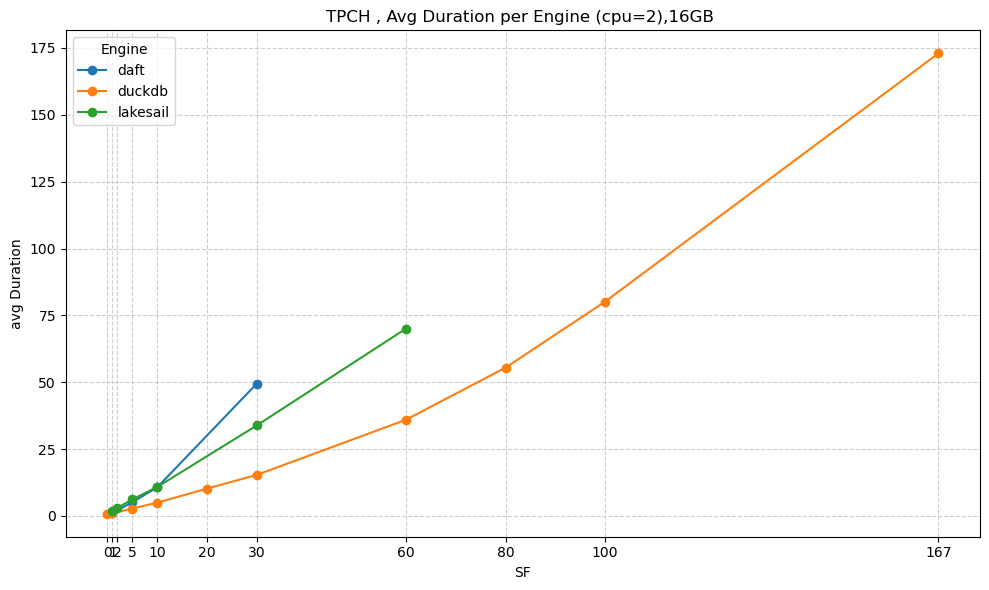

In [18]:
import matplotlib.pyplot as plt

df = DeltaTable(result_path).to_pandas(filters=[("cpu", "==", core), ("dur", ">", 0),("engine", "!=", "polars")])


final = (
    df.groupby(["engine", "cpu", "sf", "Query"], as_index=False)
    .agg(dur=("dur", "mean"))  # avg(dur) per query
    .groupby(["cpu", "sf", "engine"], as_index=False)
    .agg(
        nbr_queries=("Query", "nunique"),
        avg=("dur", "mean"),
        total=("dur", "sum")
    )
    .sort_values(by=["sf", "engine"])
)

print(final)

plt.figure(figsize=(10,6))
for engine, g in final.groupby("engine"):
    plt.plot(g["sf"], g["avg"], marker="o", label=engine)

plt.xticks(sorted(final["sf"].unique()))  

plt.xlabel("SF")
plt.ylabel("avg Duration")
plt.title(f"TPCH , Avg Duration per Engine (cpu={core}),{core*8}GB ")
plt.legend(title="Engine")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
